In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from CartPole_ import CartPole
from CartPoleNoise_ import CartPoleGaussianNoisyDyn, CartPoleGaussianNoisyObs, CartPoleGaussianNoisyObsDyn

matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'image.cmap':'jet'
})

from NonLinearObserver_ import NonLinearObserver
from LinearController_ import LinearController

from shared import get_initial_states, plot_rollout, np_to_string, get_scan_states_ranges, plot_actual_and_predicted_states_contour

In [3]:
# Task 2.3

In [4]:
target = CartPole(False)

In [5]:
# Fit linear controller

In [6]:
controller = LinearController.get_linear_controller()
controller.get_params()

array([1., 1., 1., 1.])

In [7]:
# From section 2.4, here are the ranges for which the models still tracks the system decently well

cart_pos_lim = (-2, 2)
cart_vel_lim = (-2.5, 2.5)
pole_vel_lim = (-5, 5)
pole_ang_lim = (-np.pi, np.pi)
force_lim = (-6, 6)




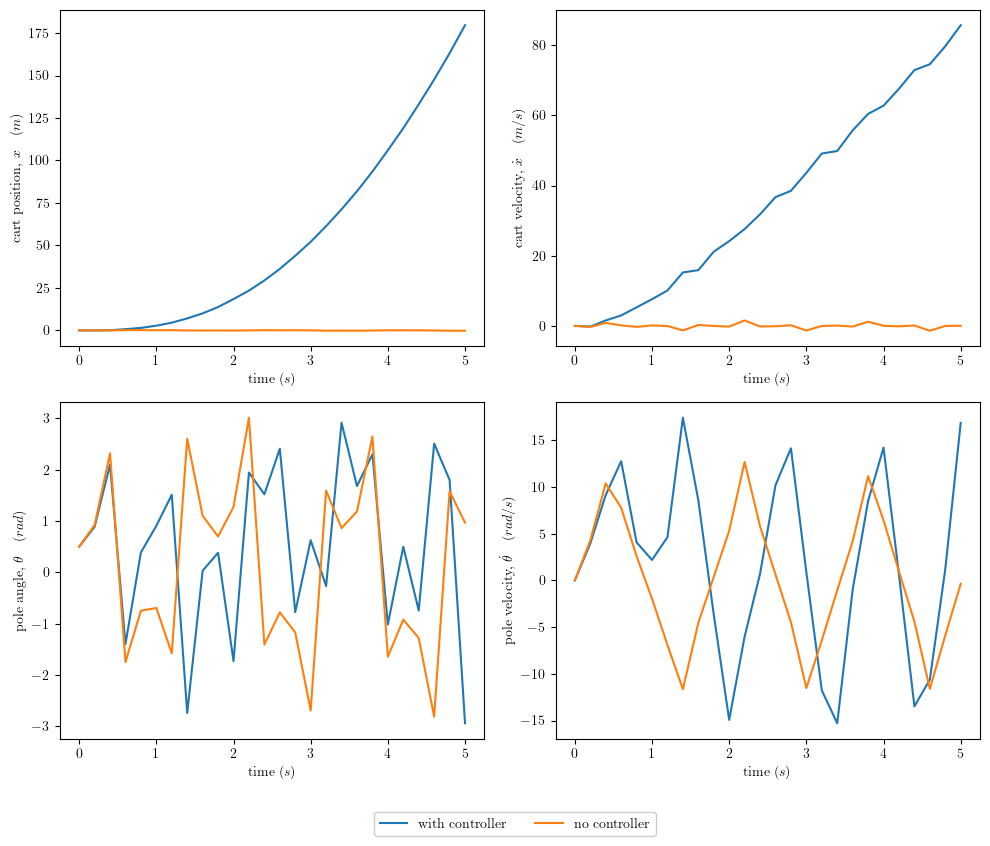

In [8]:
# Start with a 1, 1, 1, 1 controller and see roll out from (0, 0, 0.5, 0) for 5 seconds

fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')

s0 = np.array([0, 0, 0.5, 0, 0])
x, y = target.simulate_with_feedback(state=s0, remap=True, controller=controller, time=5)
x_no_controller, y_no_controller = target.simulate_with_feedback(state=s0, remap=True, controller=None, time=5)

plot_rollout(x, y, axs, fig, label='with controller')
plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)



In [1]:
# Now optimize the controller by considering loss function for initial state (0, 0, 0.5, 0) for 3 seconds

from optimizer import Optimizer

optimizer = Optimizer()

In [102]:
s0 = np.array([0, 0, 0.5, 0, 0])
p0 = controller.get_params()

optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)

(array([1., 1., 1., 1.]), 15.39346934028736)

In [40]:
# Take 1D scan 

In [8]:
n = 10
p_range = np.linspace(-3, 3, n)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    for j, p in enumerate(p_range):
        p0 = controller.get_params()
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt



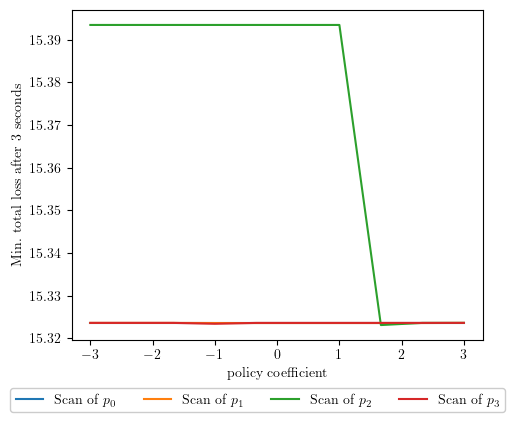

In [86]:
from shared import plot_loss_1D

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)

    

[1. 1. 1. 1.]


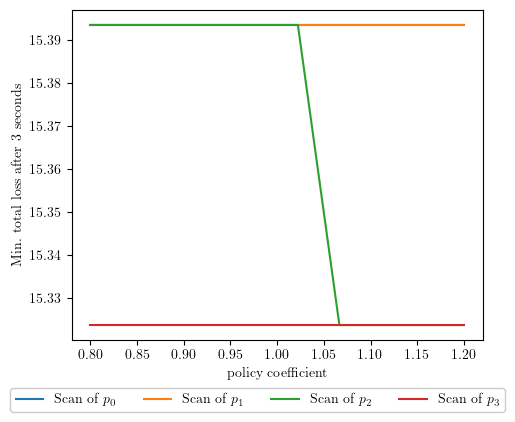

In [27]:
from optimizer import get_next_search_space_limits
from shared import plot_loss_1D

n = 10
p0 = np.ones(4)
next_search_space_limits = get_next_search_space_limits(p0, factor=5)
controller = LinearController.get_linear_controller()

print(p0)

s0 = np.array([0, 0, 0.5, 0, 0])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
xlim = (0, 0)
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    p0 = controller.get_params()
#     print(p_range)
    for j, p in enumerate(p_range):
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt
    
    xlim = min(xlim[0], p_range[0]), max(xlim[1], p_range[1])
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


In [28]:
from optimizer import get_minimum_loss

ind, _ = get_minimum_loss(loss_hist)
p_hist[ind]

array([ 2.11350045,  0.77696335, 10.39698361, -2.67076423])

In [13]:
optimizer.get_optimal_param_for_state(s0)

(array([ 2.83588686,  4.98777781, -3.35955824,  0.76869045]),
 14.523382719116375)

[-7.01767994  1.5093521  10.39602395 -2.00605958]
[-7.40374813  1.60120269 10.37598533 -1.96635865]
[-7.40374813  1.66028731 10.37598533 -1.96635865]
[-7.40374813  1.66028731 11.43562634 -1.96635865]


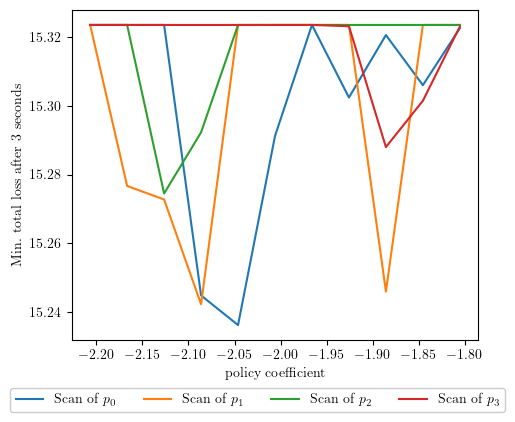

In [116]:
from optimizer import get_next_search_space_limits
# Refine search
n = 11
p0, _ = optimizer.get_optimal_param_for_state(s0)
next_search_space_limits = get_next_search_space_limits(p0, factor=10)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    p0, _ = optimizer.get_optimal_param_for_state(s0)
    
    for j, p in enumerate(p_range):
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        
        print(f"{p0}: {loss}")
        
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


[-8.14412294  1.66028731 11.43562634 -1.80545362]: 15.322695673634557
[-7.99604798  1.66028731 11.43562634 -1.80545362]: 15.304984883174768
[-7.84797302  1.66028731 11.43562634 -1.80545362]: 15.323320490915407
[-7.69989806  1.66028731 11.43562634 -1.80545362]: 15.32322355007237
[-7.55182309  1.66028731 11.43562634 -1.80545362]: 15.253236570441812
[-7.40374813  1.66028731 11.43562634 -1.80545362]: 15.323144093556326
[-7.25567317  1.66028731 11.43562634 -1.80545362]: 15.323616808148577
[-7.1075982   1.66028731 11.43562634 -1.80545362]: 15.323403869455934
[-6.95952324  1.66028731 11.43562634 -1.80545362]: 15.323617812973374
[-6.81144828  1.66028731 11.43562634 -1.80545362]: 15.2514083350952
[-6.66337332  1.66028731 11.43562634 -1.80545362]: 15.312585952538557
[-6.66337332  1.49425858 11.43562634 -1.80545362]: 15.32361781278276
[-6.66337332  1.52746433 11.43562634 -1.80545362]: 15.244857236077072
[-6.66337332  1.56067007 11.43562634 -1.80545362]: 15.32361662791154
[-6.66337332  1.59387582 

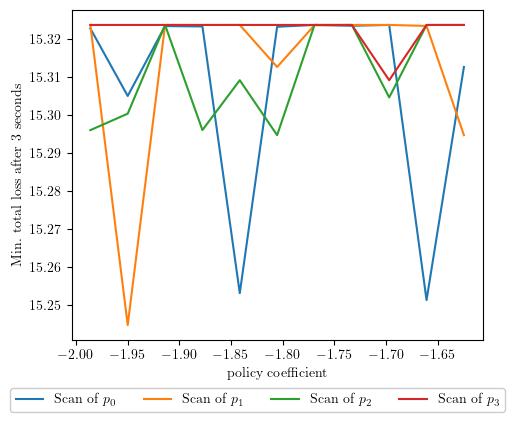

In [117]:
from optimizer import get_next_search_space_limits
# Refine search
n = 11
p0, _ = optimizer.get_optimal_param_for_state(s0)
next_search_space_limits = get_next_search_space_limits(p0, factor=10)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    p0, _ = optimizer.get_optimal_param_for_state(s0)
    
    for j, p in enumerate(p_range):
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        
        print(f"{p0}: {loss}")
        
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


[-7.32971065  1.82631604 12.57918898 -1.62490826]: 15.32361781297563
[-7.19644318  1.82631604 12.57918898 -1.62490826]: 15.3030875766445
[-7.06317572  1.82631604 12.57918898 -1.62490826]: 15.32361781297568
[-6.92990825  1.82631604 12.57918898 -1.62490826]: 15.312935070768475
[-6.79664078  1.82631604 12.57918898 -1.62490826]: 15.291188508848535
[-6.66337332  1.82631604 12.57918898 -1.62490826]: 15.323617812975332
[-6.53010585  1.82631604 12.57918898 -1.62490826]: 15.323617812975026
[-6.39683838  1.82631604 12.57918898 -1.62490826]: 15.32361781297524
[-6.26357092  1.82631604 12.57918898 -1.62490826]: 15.3236164486098
[-6.13030345  1.82631604 12.57918898 -1.62490826]: 15.323617812975515
[-5.99703599  1.82631604 12.57918898 -1.62490826]: 15.323617812975506
[-5.99703599  1.64368444 12.57918898 -1.62490826]: 15.323617812928386
[-5.99703599  1.68021076 12.57918898 -1.62490826]: 15.3236178129423
[-5.99703599  1.71673708 12.57918898 -1.62490826]: 15.32062220333584
[-5.99703599  1.7532634  12.57

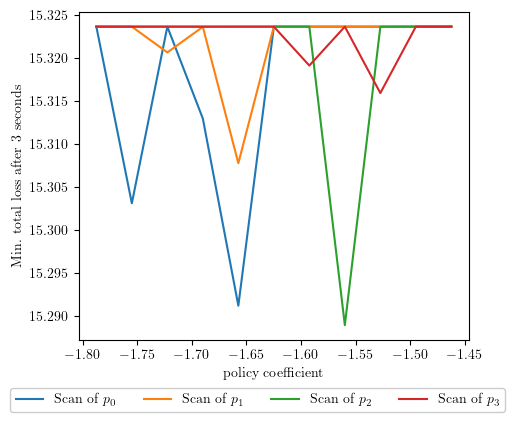

In [118]:
from optimizer import get_next_search_space_limits
# Refine search
n = 11
p0, _ = optimizer.get_optimal_param_for_state(s0)
next_search_space_limits = get_next_search_space_limits(p0, factor=10)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    p0, _ = optimizer.get_optimal_param_for_state(s0)
    
    for j, p in enumerate(p_range):
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        
        print(f"{p0}: {loss}")
        
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


In [119]:
# Now, repeat the above but with pole angle as 13

[ 0  1 13  1]: 15.323617812975339
[ 0  1 13  1]: 15.323617812975339
[ 0  1 13  1]: 15.323617812975339
[ 0  1 13  1]: 15.323617812975339
[ 0  1 13  1]: 15.323617812975339
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  0 13  1]: 15.323617812975263
[ 1  0 13  1]: 15.323617812975263
[ 1  0 13  1]: 15.323617812975263
[ 1  0 13  1]: 15.323617812975263
[ 1  0 13  1]: 15.323617812975263
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 10  1]: 15.323617812975344
[ 1  1 10  1]: 15.323617812975344
[ 1  1 11  1]: 15.323617812975247
[ 1  1 12  1]: 15.323617812975316
[ 1  1 12  1]: 15.323617812975316
[ 1  1 13  1]: 15.323617812975534
[ 1  1 13  1]: 15.323617812975534
[ 1  1 14  1]: 15.323617812975279
[ 1  1 15  1]: 15.32361781297539
[ 1  1 15  1]: 

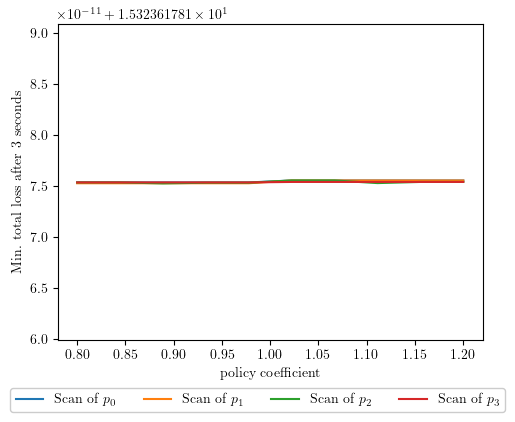

In [127]:
from optimizer import get_next_search_space_limits

n = 10
p_prev = np.array([1, 1, 13, 1])
next_search_space_limits = get_next_search_space_limits(p0, factor=5)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    for j, p in enumerate(p_range):
        p0 = p_prev[:]
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        print(f"{p0}: {loss}")
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


[ 0  1 13  2]: 5.399561045403045
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  0 13  2]: 15.323617812975243
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 13  2]: 15.323617812975296
[ 1  1 17  2]: 5.399561046378789
[ 1  1 18  2]: 5.399561047425472
[ 1  1 19  2]: 5.399561045123609
[ 1  1 20  2]: 5.399561044318391
[ 1  1 21  2]: 5.399561050887868
[ 1  1 22  2]: 5.399561045143629
[ 1  1 23  2]: 5.399561047501244
[ 1  1 24  2]: 3.8669295072746777
[ 1  1 24  2]: 3.8669295072746777
[ 1  1 25  2]: 5.39956

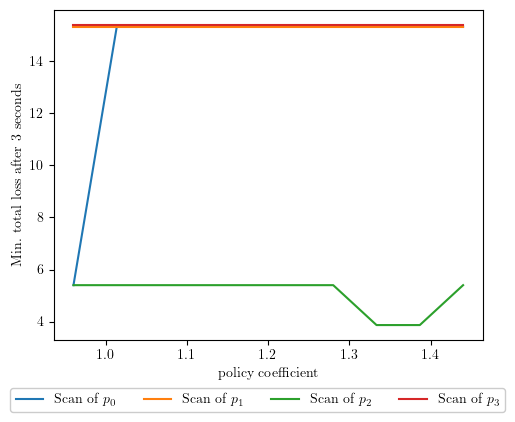

In [130]:
from optimizer import get_next_search_space_limits

n = 10
p_prev = np.array([1, 1, 13, 2])
next_search_space_limits = get_next_search_space_limits(p0, factor=5)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    for j, p in enumerate(p_range):
        p0 = p_prev[:]
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        print(f"{p0}: {loss}")
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


[ 2.74032973  3.26174617 22.83632247  3.59807873]


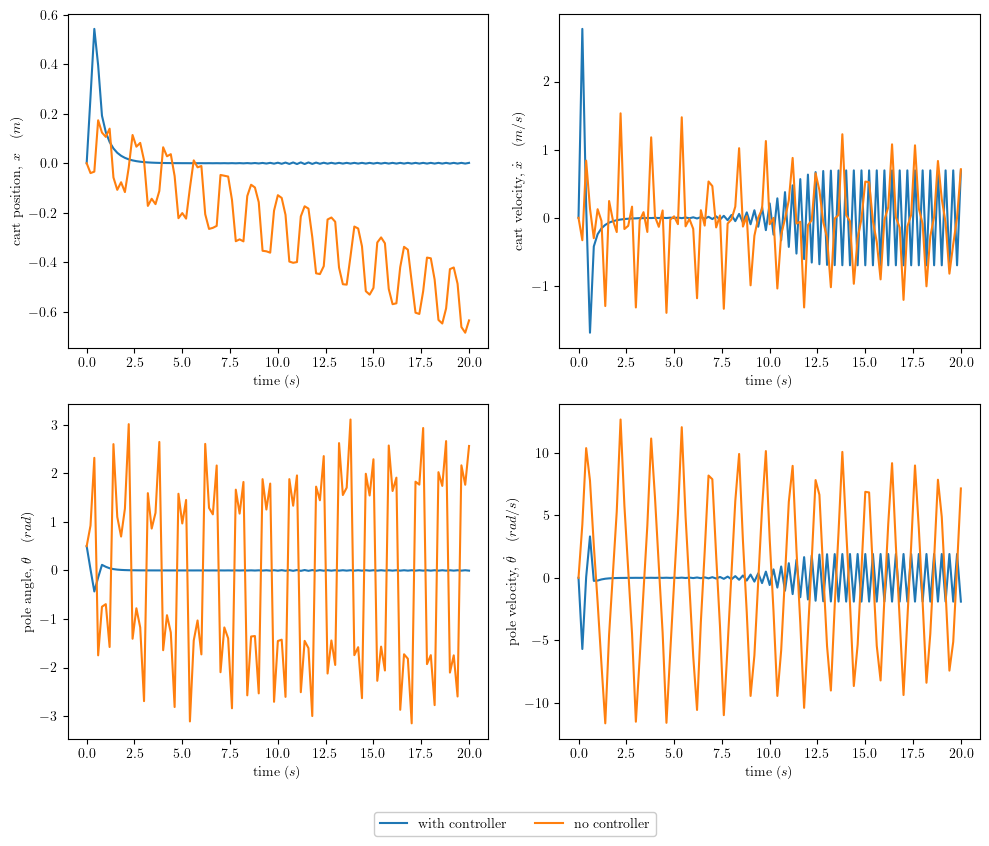

In [134]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')
s0 = np.array([0, 0, 0.5, 0, 0])

controller.p, _ = optimizer.get_optimal_param_for_state(s0)
print(controller.p)

x, y = target.simulate_with_feedback(state=s0, remap=True, controller=controller, time=20)
x_no_controller, y_no_controller = target.simulate_with_feedback(state=s0, remap=True, controller=None, time=20)

plot_rollout(x, y, axs, fig, label='with controller')
plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)



NameError: name 'x_hat' is not defined

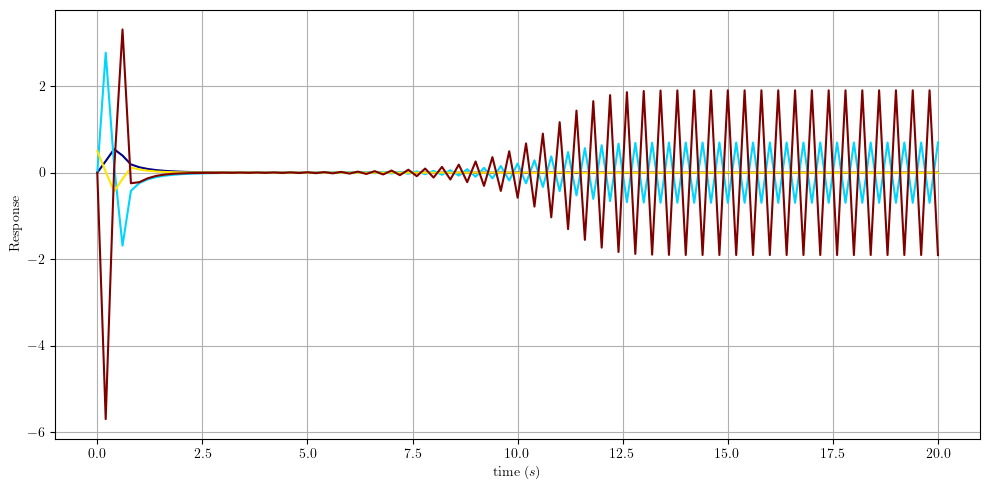

In [14]:
from shared import plot_rollout_single 
from optimizer import Optimizer

n = 4
colors = plt.cm.jet(np.linspace(0, 1, n))
fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout='tight')

optimizer = Optimizer()
s0 = np.array([0, 0, 0.5, 0, 0])

controller.p =  [2.74032973,  3.26174617, 22.83632247,  3.59807873]

x, y = target.simulate_with_feedback(state=s0, remap=True, controller=controller, time=20)
x_no_controller, y_no_controller = target.simulate_with_feedback(state=s0, remap=True, controller=None, time=20)

plot_rollout_single(x, y, ax, fig, color=colors, linestyle='solid', legend=True)
plot_rollout_single(x_hat, y_hat, ax, fig, color=colors, linestyle='dotted', legend=False)
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)



In [ ]:
from optimizer import get_next_search_space_limits

n = 10
p_prev = controller.p
next_search_space_limits = get_next_search_space_limits(p0, factor=20) # Fine tuning

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    for j, p in enumerate(p_range):
        p0 = p_prev[:]
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=3, remap=True)
        print(f"{p0}: {loss}")
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


[ 1.05  1.05 26.25  1.05]


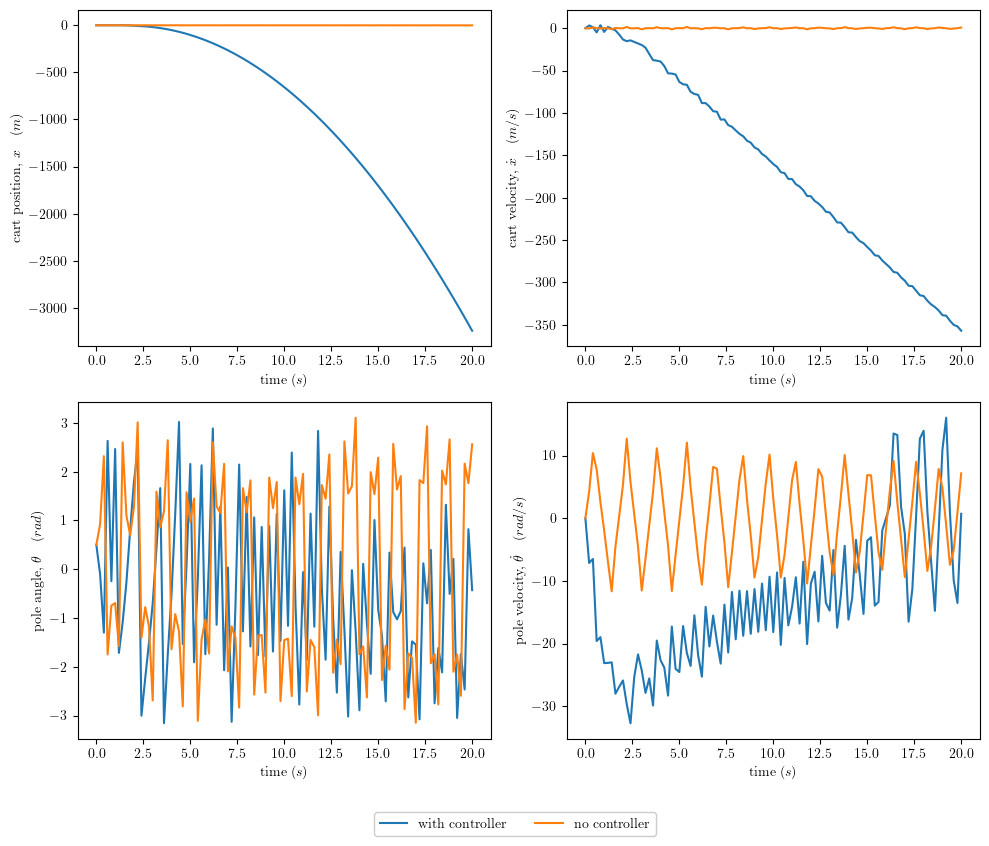

In [136]:
# Start with a 1, 1, 1, 1 controller and see roll out from (0, 0, 0.5, 0) for 5 seconds

fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')
s0 = np.array([0, 0, 0.5, 0, 0])

controller.p, _ = optimizer.get_optimal_param_for_state(s0)
print(controller.p)

x, y = target.simulate_with_feedback(state=s0, remap=True, controller=controller, time=20)
x_no_controller, y_no_controller = target.simulate_with_feedback(state=s0, remap=True, controller=None, time=20)

plot_rollout(x, y, axs, fig, label='with controller')
plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)



In [ ]:
# Now try loss with feedback penalty, starting from 1, 1, 13, 2 again

In [ ]:
# from optimizer import get_next_search_space_limits

n = 10
p_prev = np.array([1, 1, 13, 2])
next_search_space_limits = get_next_search_space_limits(p0, factor=5)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    for j, p in enumerate(p_range):
        p0 = p_prev[:]
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
        print(f"{p0}: {loss}")
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


[ 0,  1, 14,  2]: 5.358303343571998
[ 0,  1, 14,  2]: 5.358303343571998
[ 0,  1, 14,  2]: 5.358303343571998
[ 0,  1, 14,  2]: 5.358303343571998
[ 0,  1, 14,  2]: 5.358303343571998
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  0, 14,  2]: 9.99401098497464
[ 1,  0, 14,  2]: 9.99401098497464
[ 1,  0, 14,  2]: 9.99401098497464
[ 1,  0, 14,  2]: 9.99401098497464
[ 1,  0, 14,  2]: 9.99401098497464
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 13,  2]: 6.121458963548887
[ 1,  1, 13,  2]: 6.121458963548887
[ 1,  1, 13,  2]: 6.121458963548887
[ 1,  1, 13,  2]: 6.121458963548887
[ 1,  1, 13,  2]: 6.121458963548887
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  2]: 51.0
[ 1,  1, 14,  1]: 51.0
[ 1,  1, 14,  1]: 51.0
[ 1,  1, 14,  1]: 51.0
[ 1,  1, 14,  1]: 51.0
[ 1,  1, 14,  1]: 51.0
[ 1, 

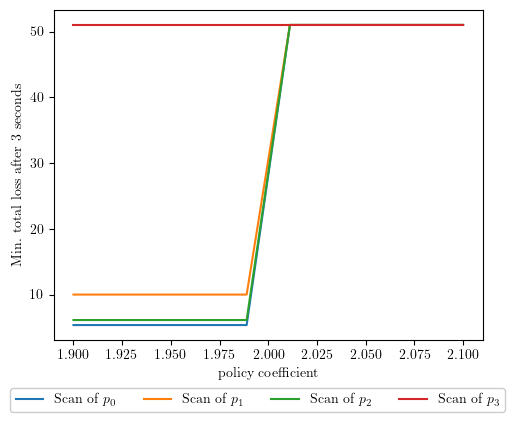

In [152]:
from optimizer import get_next_search_space_limits

n = 10
p_prev = np.array([ 1,  1, 14,  2,])
next_search_space_limits = get_next_search_space_limits(p_prev, factor=20)

s0 = np.array([0, 0, 0.5, 0, 0])

loss_hist = np.zeros((n, 4))
p_hist = np.zeros((n, 4, 4))
for i in range(4):
    from_val = next_search_space_limits[i][0]
    to_val = next_search_space_limits[i][1]
    p_range = np.linspace(from_val, to_val, n)
    for j, p in enumerate(p_range):
        p0 = p_prev[:]
        p0[i] = p
        p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
        print(f"{np_to_string(p0)}: {loss}")
        loss_hist[j, i] = loss
        p_hist[j, i] = p_opt

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(p_range, loss_hist[:, i], label=f"Scan of $p_{i}$", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=4)


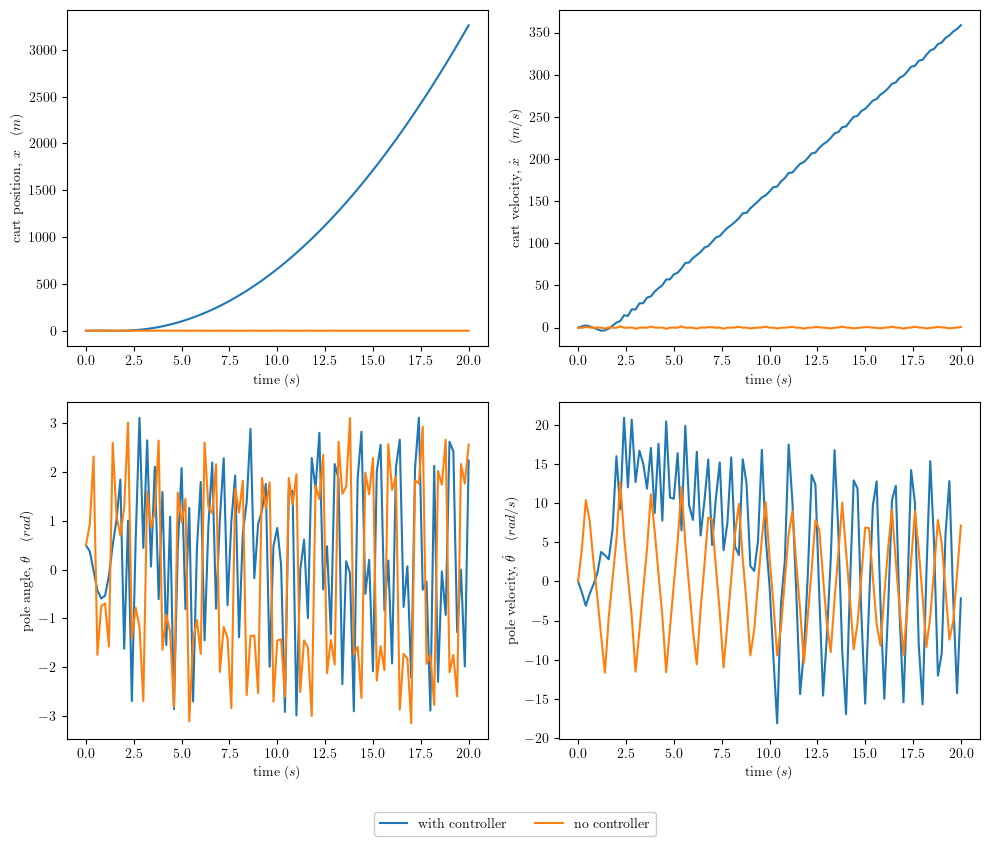

In [154]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')
s0 = np.array([0, 0, 0.5, 0, 0])

controller.p = np.array([ 0,  1, 14,  2])

x, y = target.simulate_with_feedback(state=s0, remap=True, controller=controller, time=20)
x_no_controller, y_no_controller = target.simulate_with_feedback(state=s0, remap=True, controller=None, time=20)

plot_rollout(x, y, axs, fig, label='with controller')
plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)



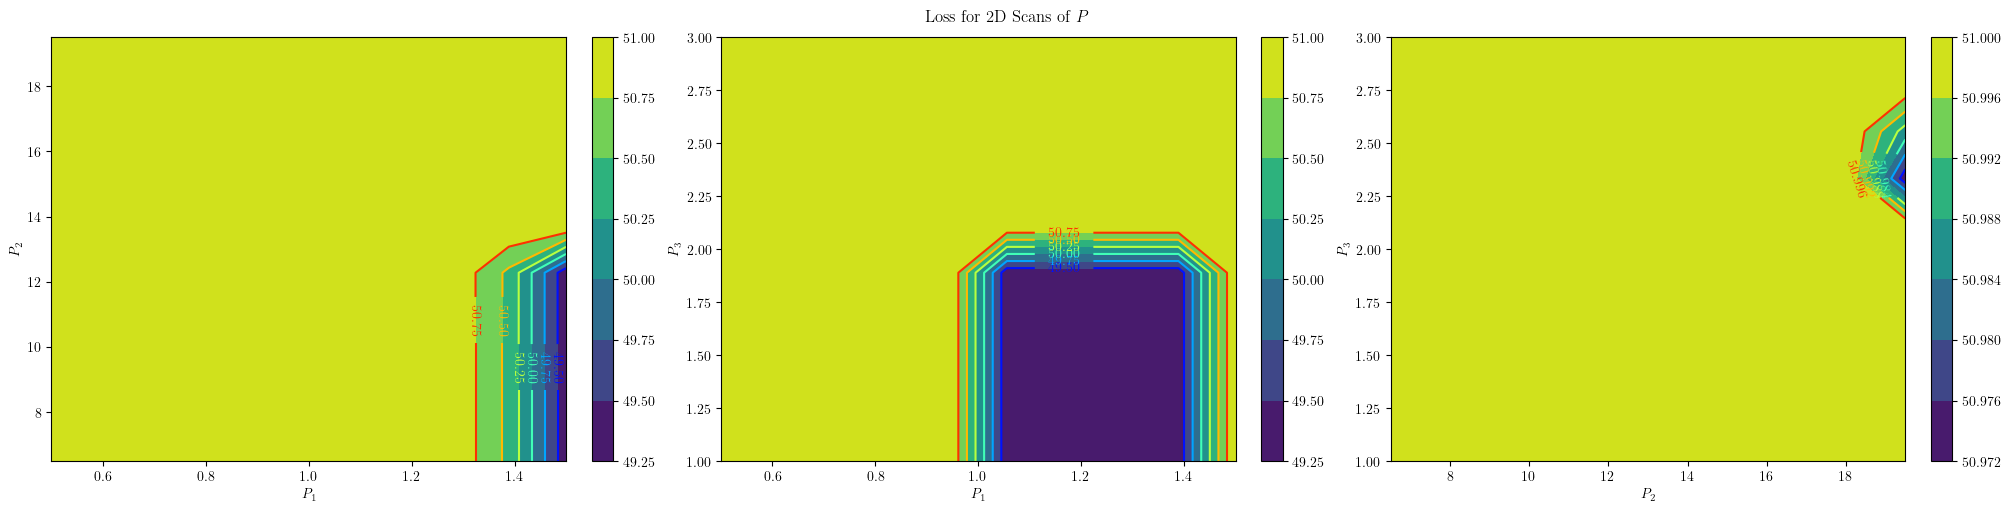

In [192]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1, 13, 2])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=2)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_1.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                 p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_1.png")


In [ ]:
# P1 has nothing in common
# P2 has nothing in common
# p3 has nothing in common
# Hence, instead lets shift p1 to 1.2

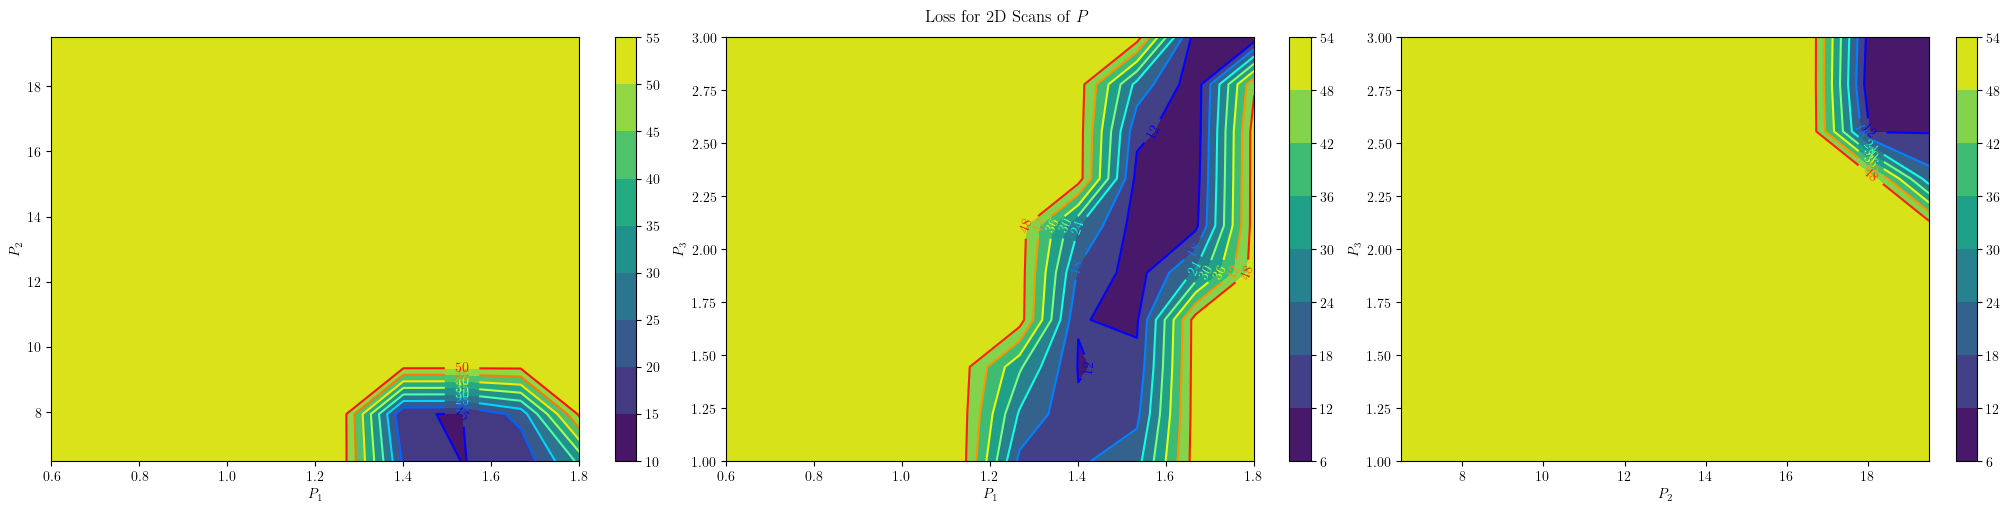

In [200]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1.2, 13, 2])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=2)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_2.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                 p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_2.png")


In [201]:
# P1 = (1.4, 1.7), P2 = (6, 8) 
# P1 = (1.5, 1.7), p3 = (2, 2.75)
# P2 = (18, 19), p3 = (2.5, 3)

# We finally have points in common
# Move p3 to 2.75


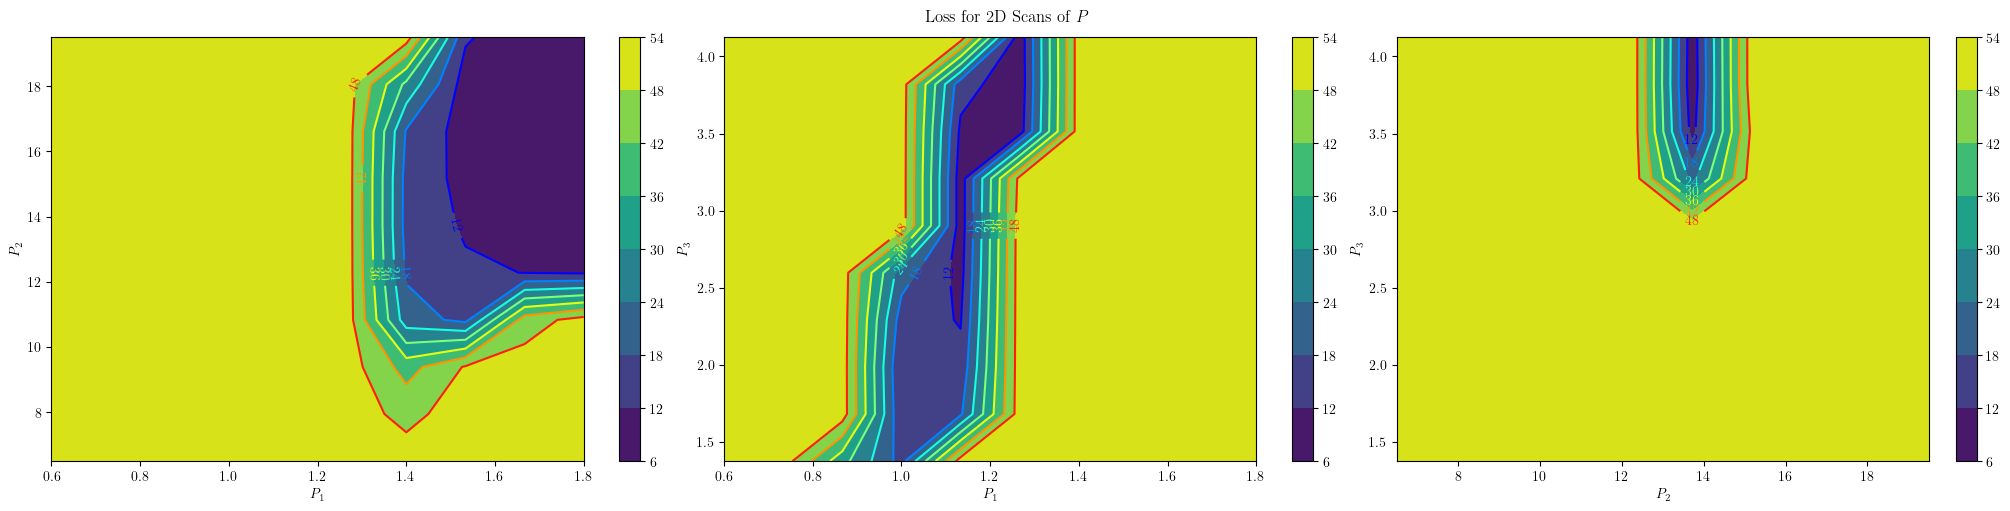

In [202]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1.2, 13, 2.75])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=2)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_3.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                 p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_3.png")


In [ ]:
# P1 = (1.5, 1.8), P2 = (12, 20) 
# P1 = (1.2), p3 = (3.5)
# P2 = (14), p3 = (3.5 , 4)

# P1 has no points in common
# p3 has still no good rangees
# We finally have points in common
# Move p3 to 16


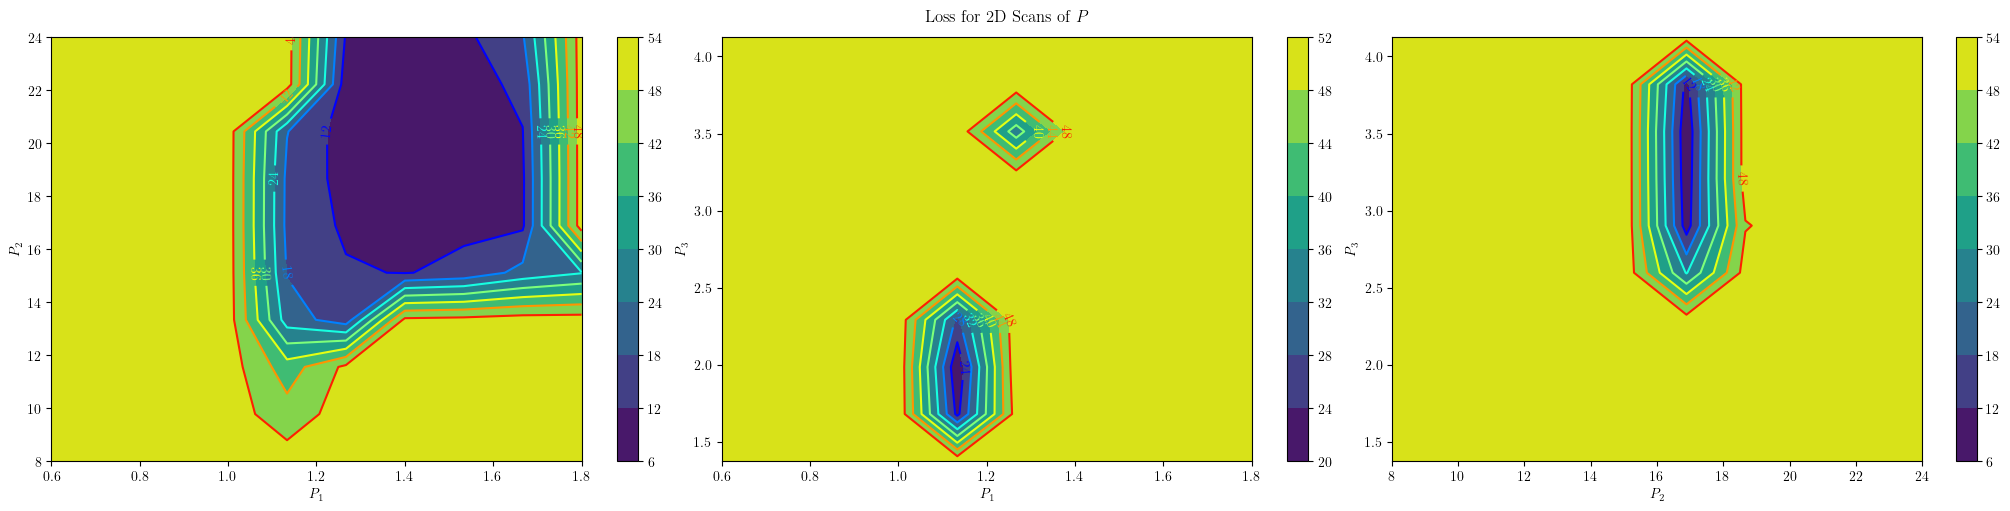

In [203]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1.2, 16, 2.75])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=2)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_4.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                 p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_4.png")
# 0.76, 1.44, 17.06, 2.66

In [204]:
# No progress, maybe try p0 now

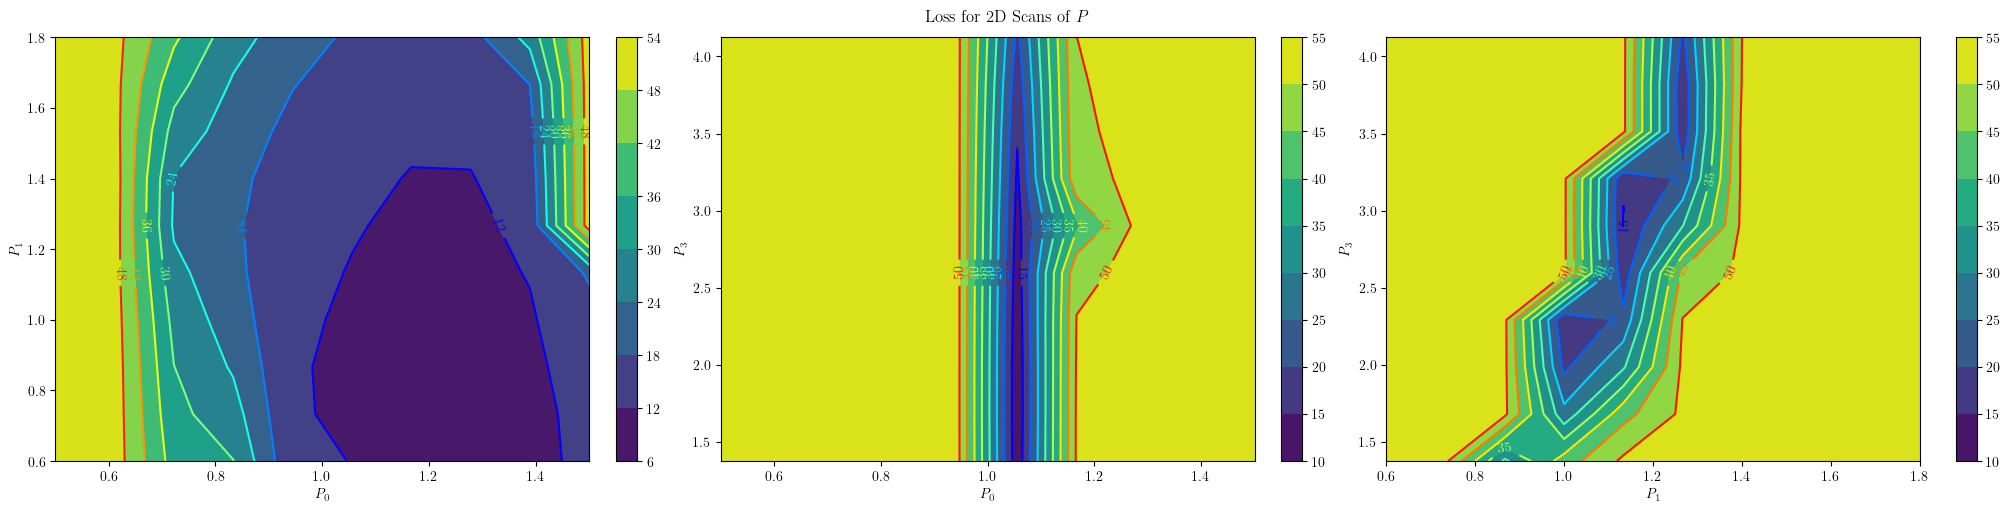

In [205]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1.2, 16, 2.75])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=2)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_5.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([0, 1, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                 p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_5.png")


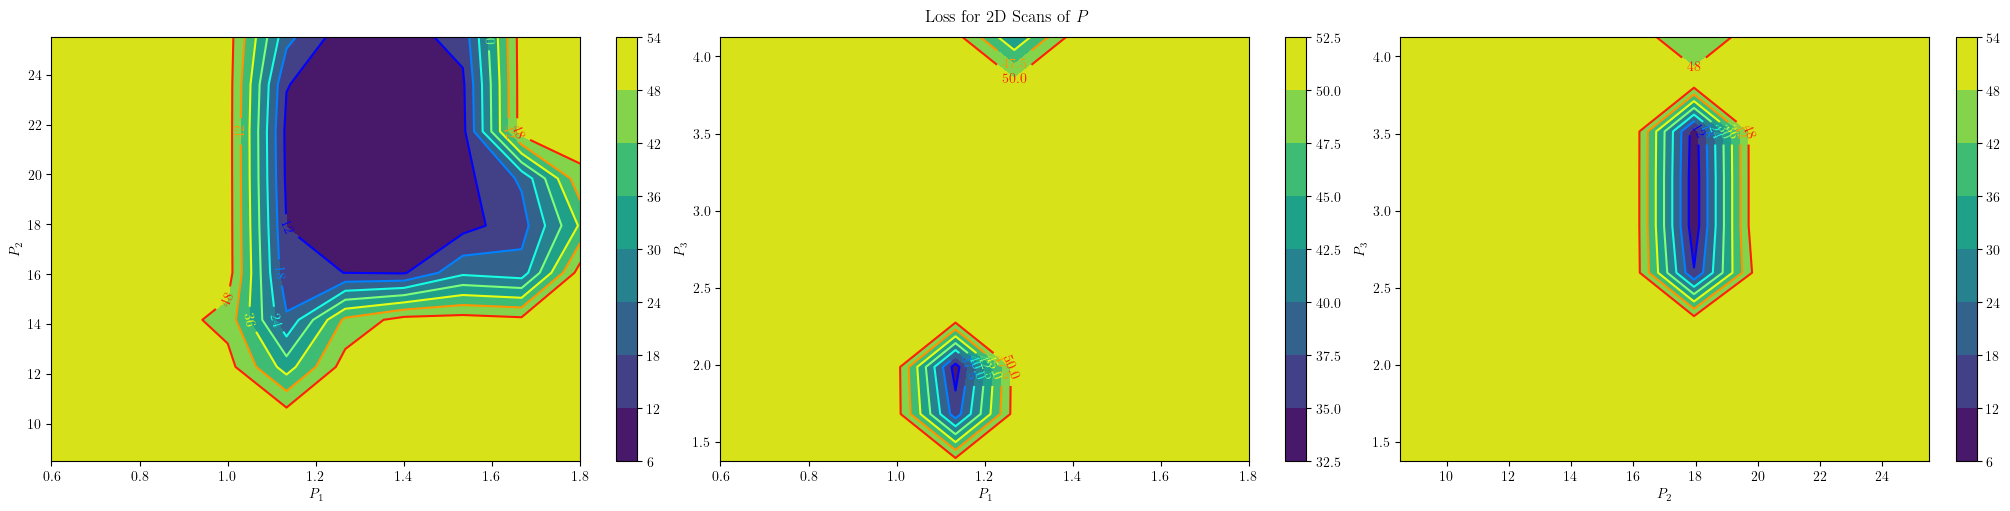

In [207]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1.2, 17, 2.75])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=2)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_6.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                 p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_6.png")


In [ ]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1.2, 16, 2.75])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=2)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_5.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                 p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_5.png")


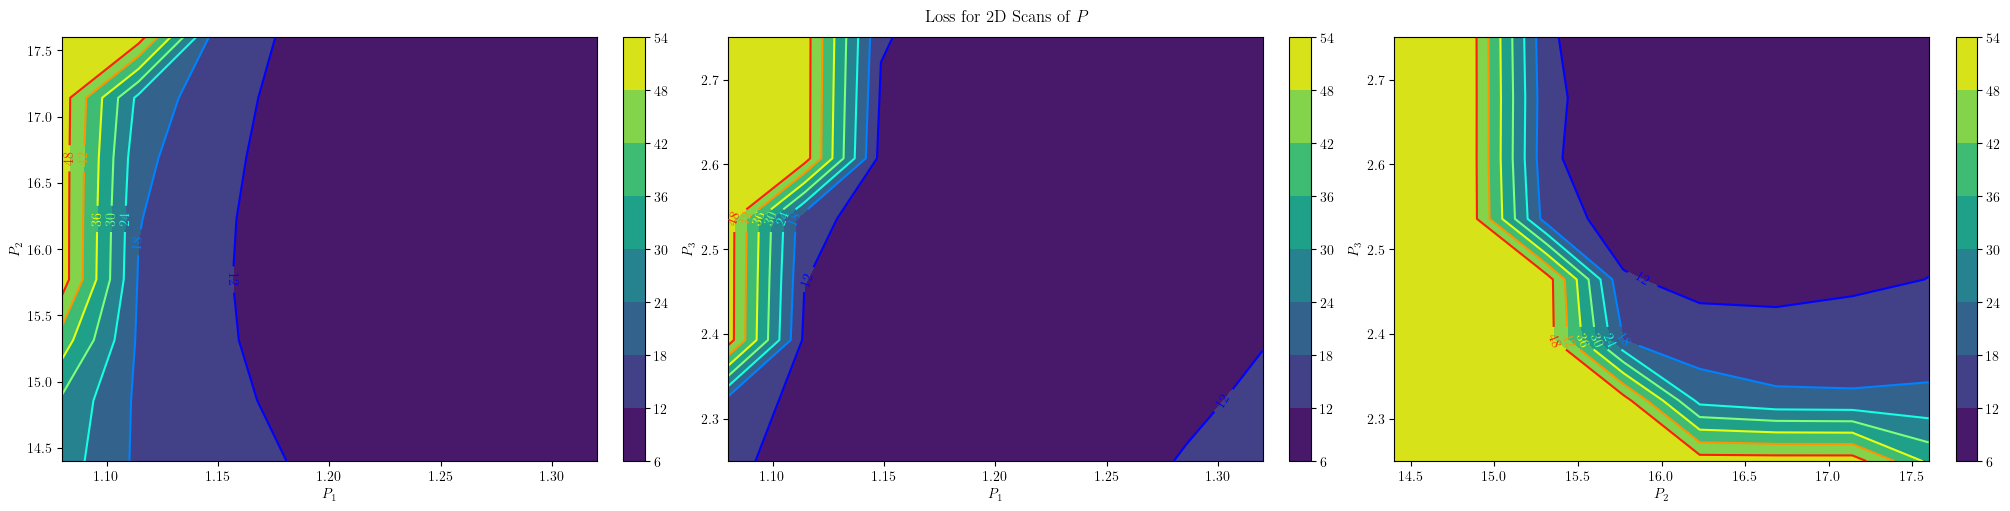

In [199]:
from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 15
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([1, 1.2, 16, 2.75])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=10)
[0.76193829,  1.19125407, 16.33103061,  2.49340746]

loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_1.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
#                  p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=2, time=10, remap=True)
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_1.png")


In [ ]:
# Optimize

In [214]:
from optimizer import get_next_search_space_limits

p0 = np.array([1, 1.2, 16, 2.75])

s0 = np.array([0, 0, 0.5, 0, 0])

p_opt, loss = optimizer.optimize_linear(target, controller, s0, p0, verbose=False, loss_func=1, time=10, remap=True)

p_opt, loss


(array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818]),
 5.399664944901432)

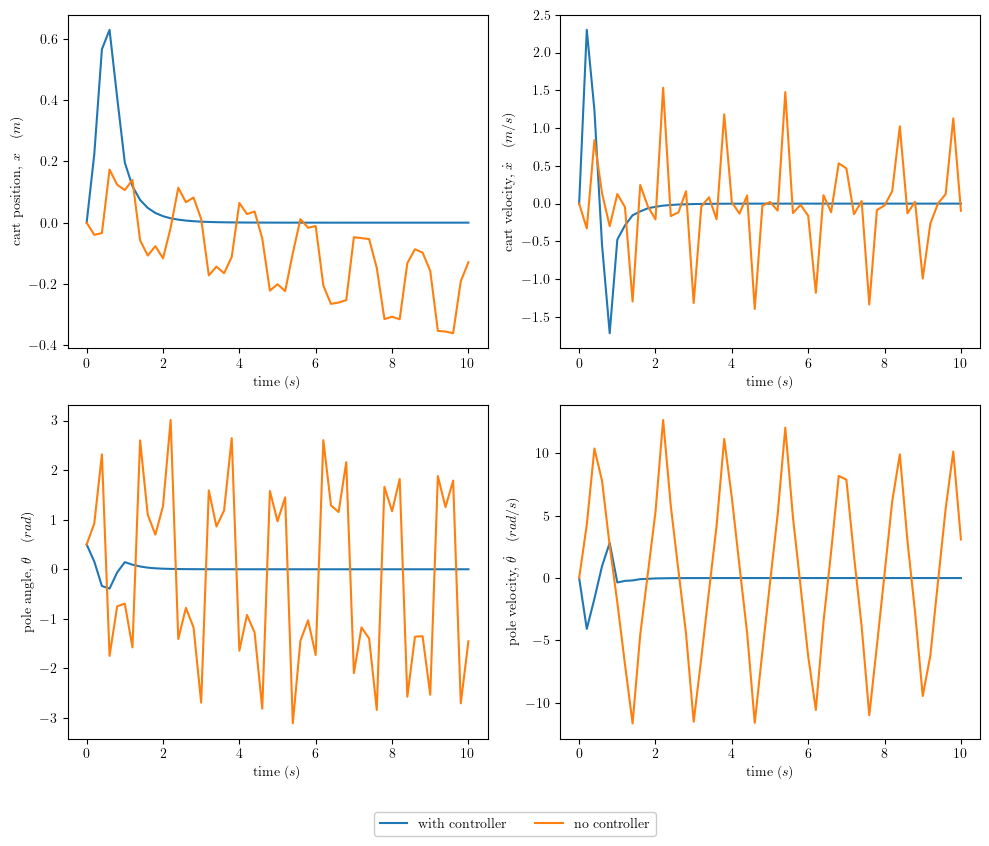

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), layout='tight')
s0 = np.array([0, 0, 0.5, 0, 0])

controller.p = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])

x, y = target.simulate_with_feedback(state=s0, remap=True, controller=controller, time=10)
x_no_controller, y_no_controller = target.simulate_with_feedback(state=s0, remap=True, controller=None, time=10)

plot_rollout(x, y, axs, fig, label='with controller')
plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)



NameError: name 'x_hat' is not defined

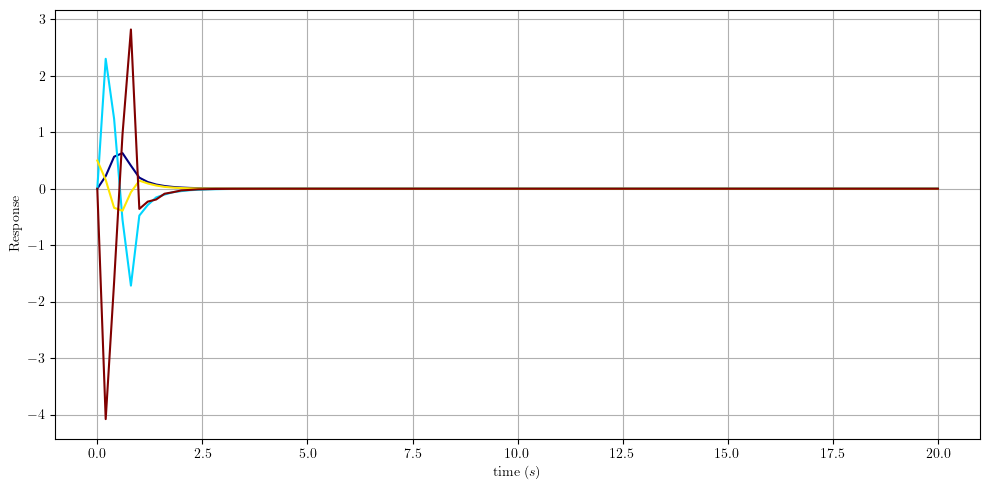

In [15]:
from shared import plot_rollout_single 
from optimizer import Optimizer

n = 4
colors = plt.cm.jet(np.linspace(0, 1, n))
fig, ax = plt.subplots(1, 1, figsize=(10, 5), layout='tight')

optimizer = Optimizer()
s0 = np.array([0, 0, 0.5, 0, 0])

controller.p = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
x, y = target.simulate_with_feedback(state=s0, remap=True, controller=controller, time=10)
x_no_controller, y_no_controller = target.simulate_with_feedback(state=s0, remap=True, controller=None, time=10)

plot_rollout_single(x, y, ax, fig, color=colors, linestyle='solid', legend=True)
plot_rollout_single(x_hat, y_hat, ax, fig, color=colors, linestyle='dotted', legend=False)
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)



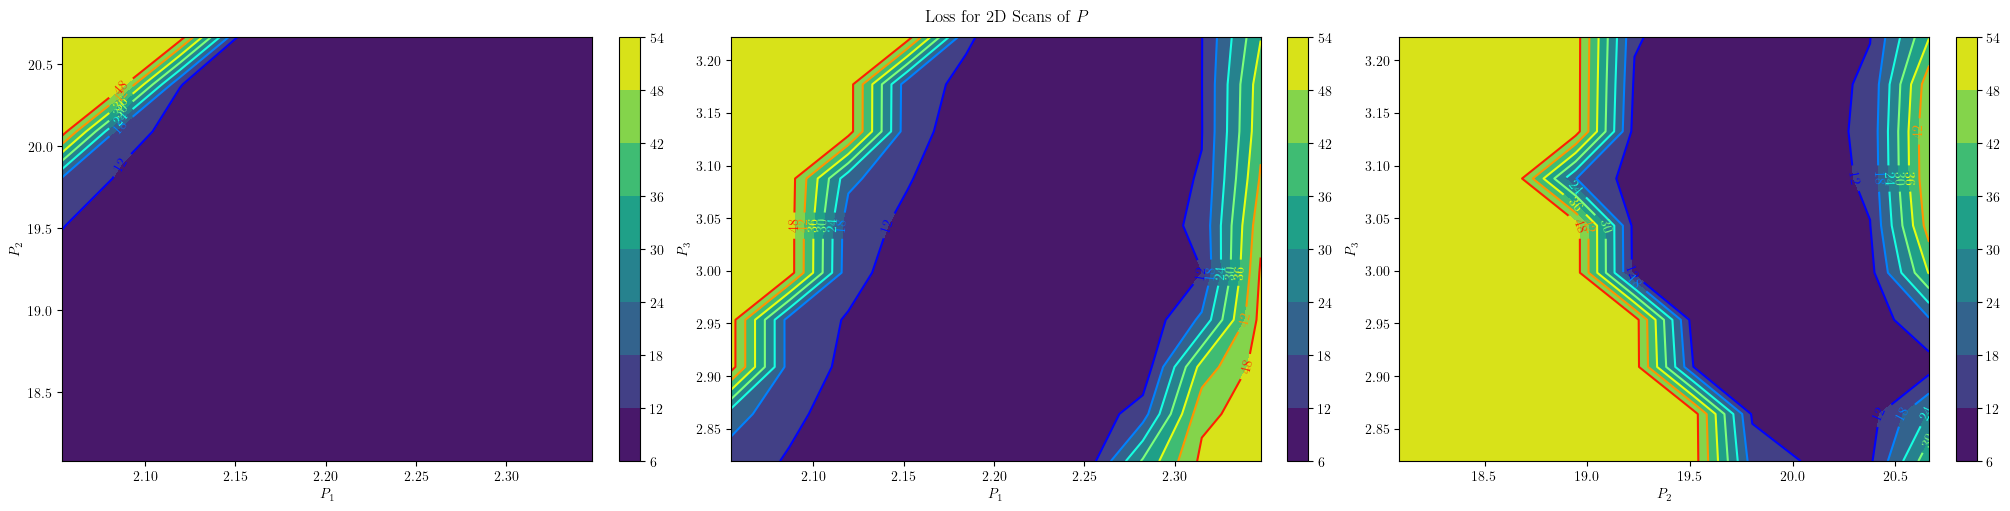

In [220]:
# Get values of p

from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0, 0, 0.5, 0, 0])
w_prev = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
next_search_space_limits = get_next_search_space_limits(w_prev, factor=15)


loss_hist = np.zeros((3, n, n))
w_hist = np.zeros((3, n, n, 4))
file_path = f"optimization_logs/t2_3_optimization_2d_20.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = np.linspace(next_search_space_limits[p][0], next_search_space_limits[p][1], n)
        range_y = np.linspace(next_search_space_limits[q][0], next_search_space_limits[q][1], n)

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                w = w_prev[:]
                w[p] = x[i][j]
                w[q] = y[i][j]
                loss = optimizer.total_loss_with_feedback(target, controller, s0, w, time=10, remap=True)
                loss_hist[k, j, i] = loss
                w_hist[k, j, i] = w
            
                line = f"{np_to_string(w)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])

fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__optimization_2d_20.png")


In [ ]:
# We can get approximate ranges from here

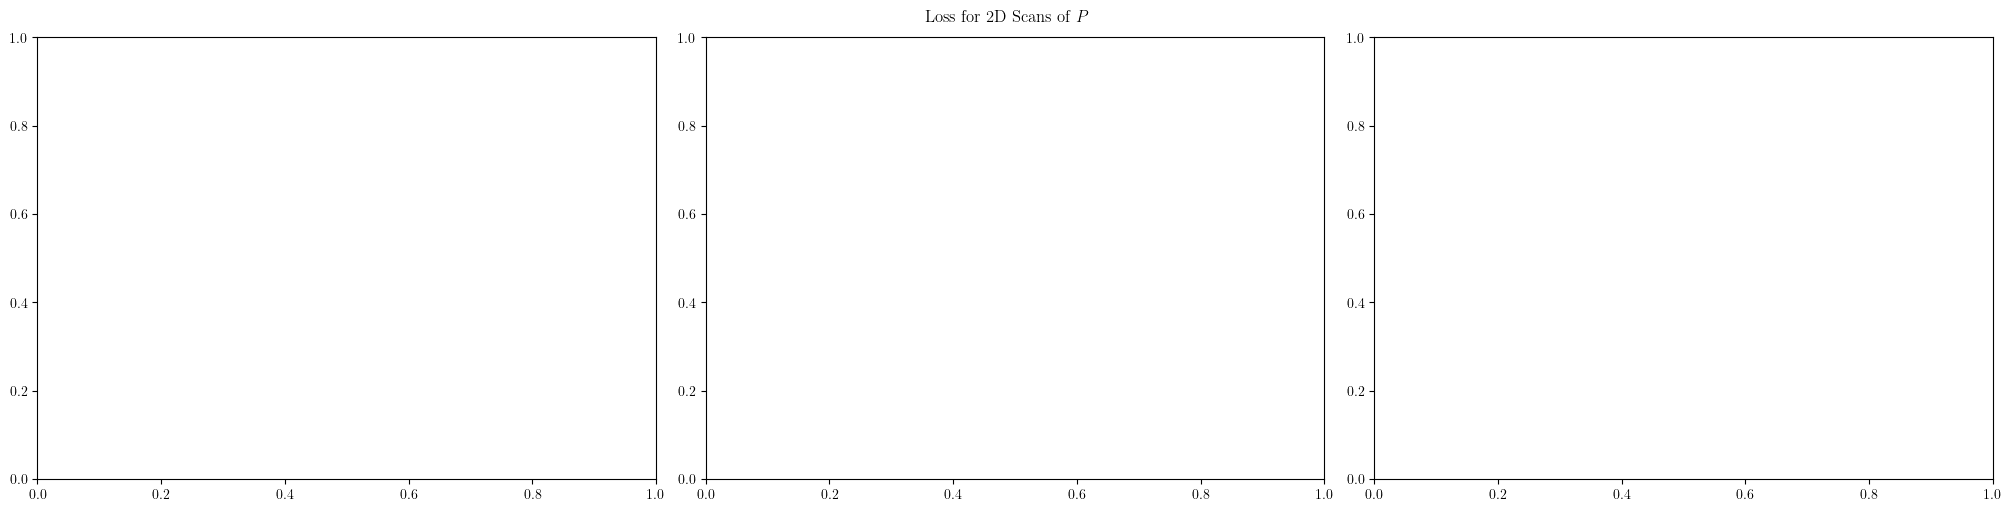

In [18]:
# # Get values of p

# from shared import plot_loss_2D
# from itertools import combinations
# from optimizer import Optimizer

# optimizer = Optimizer()

# fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

# n = 10
# s0 = np.array([0, 0, 0.01, 0, 0])
# p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
# controller.p = p_opt


# limits = (
#     (-0.1, -0.0875),
#     (-0.1, 0.1),
#     (0.45, 0.55),
#     (-0.1, 0),
#     force_lim
# )
# scan_state_ranges = get_scan_states_ranges(n, limits)


# loss_hist = np.zeros((3, n, n))
# file_path = f"optimization_logs/t2_3_operating_range_2d.log"

# with open(file_path, "w") as file:
#     for k, c in enumerate(combinations([1, 2, 3], 2)):
#         p, q = c
#         range_x = scan_state_ranges[p]
#         range_y = scan_state_ranges[q]

#         x, y = np.meshgrid(range_x, range_y, indexing='ij')
#         for i in range(len(x)):
#             for j in range(len(y)):
#                 s = s0[:]
#                 s[p] = x[i][j]
#                 s[q] = y[i][j]
#                 loss = optimizer.total_loss_with_feedback(target, controller, s, p_opt, time=10, remap=True)
#                 loss_hist[k, j, i] = loss
            
#                 line = f"{np_to_string(s)}: {loss}"
#                 file.write(line + "\n")
        

# fig.suptitle('Loss for 2D Scans of $P$')
# fig.savefig("./assets2_revised/t2_3__operating_range_2d.png")


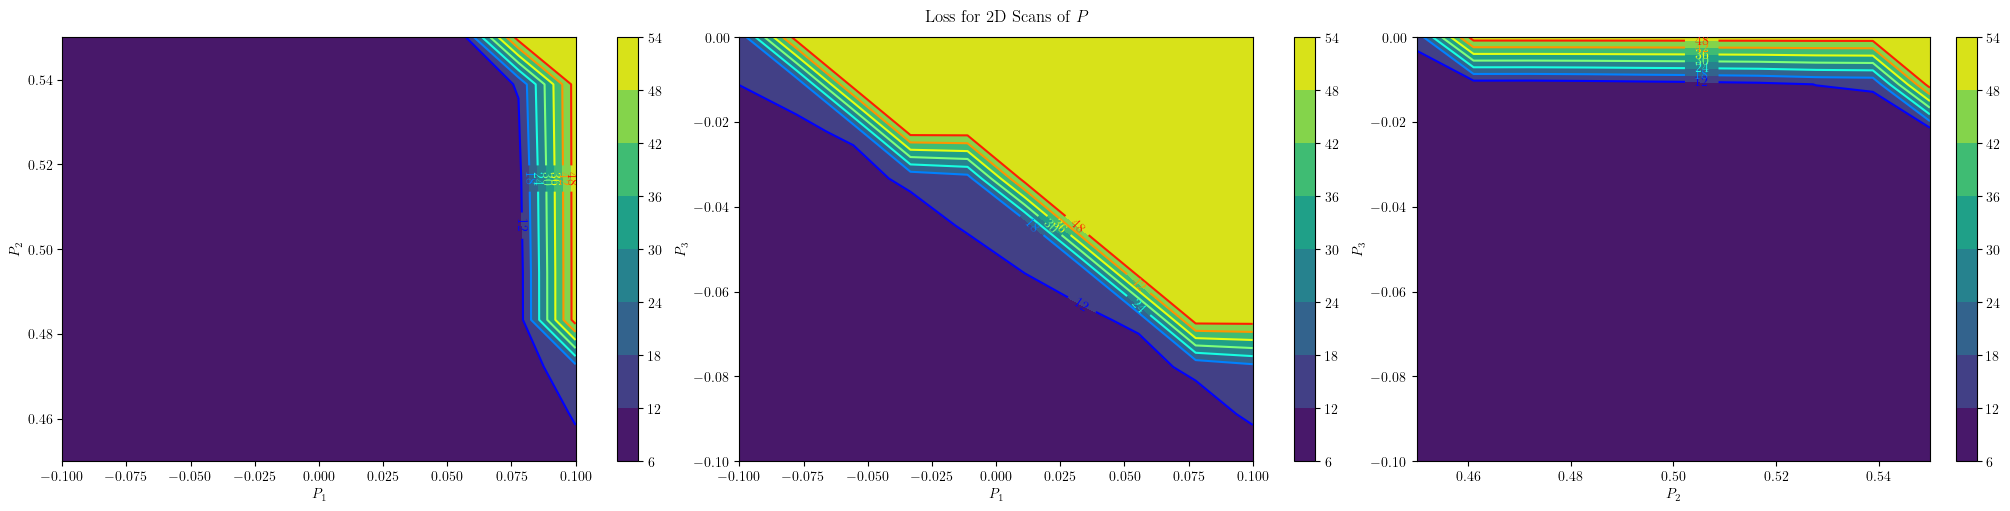

In [34]:
# # Get values of p

# from shared import plot_loss_2D
# from itertools import combinations

# fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

# n = 10
# s0 = np.array([0, 0, 0.01, 0, 0])
# p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
# controller.p = p_opt


# limits = (
#     (-0.1, -0.0875),
#     (-0.1, 0.1),
#     (0.45, 0.55),
#     (-0.1, 0),
#     force_lim
# )
# scan_state_ranges = get_scan_states_ranges(n, limits)


# loss_hist = np.zeros((3, n, n))
# file_path = f"optimization_logs/t2_3_operating_range_2d.log"

# with open(file_path, "w") as file:
#     for k, c in enumerate(combinations([1, 2, 3], 2)):
#         p, q = c
#         range_x = scan_state_ranges[p]
#         range_y = scan_state_ranges[q]

#         x, y = np.meshgrid(range_x, range_y, indexing='ij')
#         for i in range(len(x)):
#             for j in range(len(y)):
#                 s = s0[:]
#                 s[p] = x[i][j]
#                 s[q] = y[i][j]
#                 loss = optimizer.total_loss_with_feedback(target, controller, s, p_opt, time=10, remap=True)
#                 loss_hist[k, j, i] = loss
            
#                 line = f"{np_to_string(s)}: {loss}"
#                 file.write(line + "\n")
        
#         plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])
# #         plot_rollout(x, y, axs, fig, label='with controller')
# #         plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
# #         fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)


# fig.suptitle('Loss for 2D Scans of $P$')
# fig.savefig("./assets2_revised/t2_3__operating_range_2d.png")


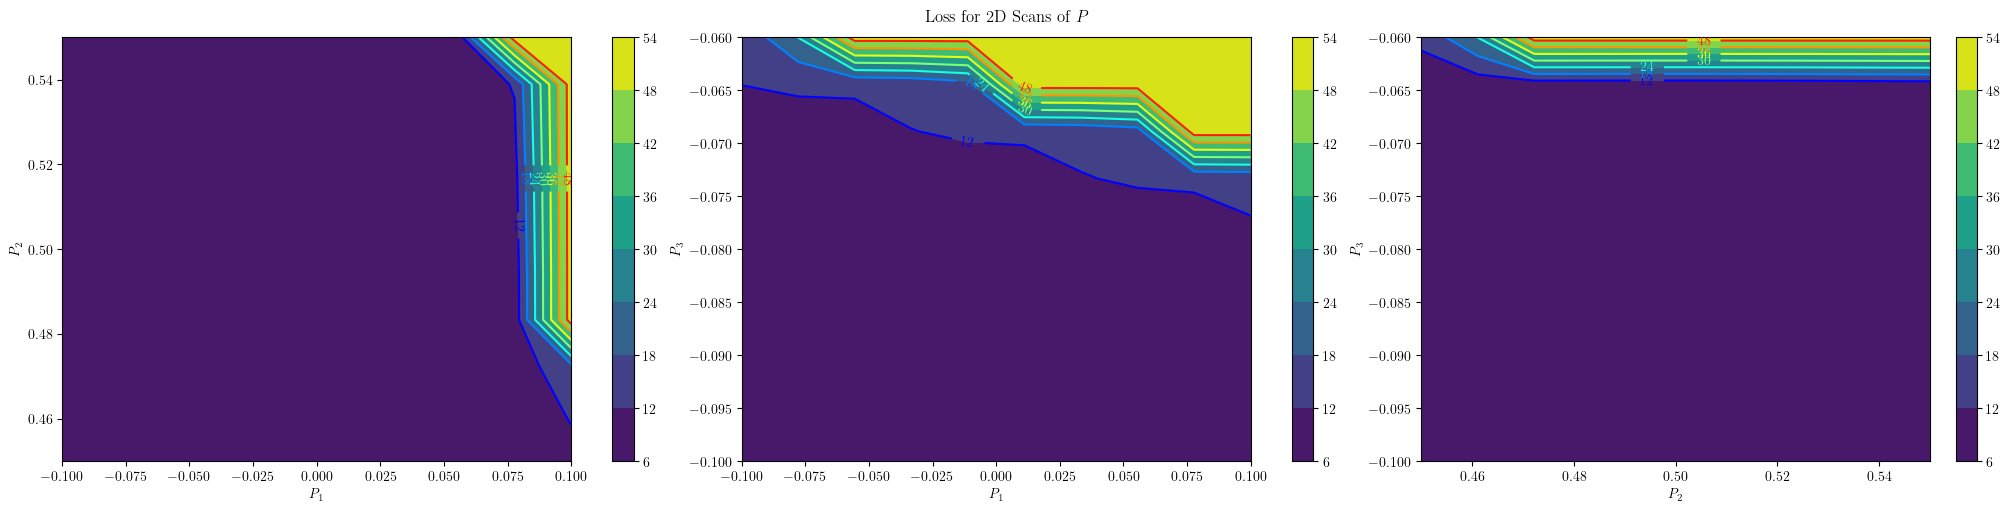

In [35]:
# # Get values of p

# from shared import plot_loss_2D
# from itertools import combinations

# fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

# n = 10
# s0 = np.array([0, 0, 0.5, 0, 0])
# p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
# controller.p = p_opt


# limits = (
#     (-0.1, 0),
#     (-0.1, 0.1),
#     (0.45, 0.55),
#     (-0.1, -0.06),
#     force_lim
# )
# scan_state_ranges = get_scan_states_ranges(n, limits)


# loss_hist = np.zeros((3, n, n))
# file_path = f"optimization_logs/t2_3_operating_range_2d.log"

# with open(file_path, "w") as file:
#     for k, c in enumerate(combinations([1, 2, 3], 2)):
#         p, q = c
#         range_x = scan_state_ranges[p]
#         range_y = scan_state_ranges[q]

#         x, y = np.meshgrid(range_x, range_y, indexing='ij')
#         for i in range(len(x)):
#             for j in range(len(y)):
#                 s = s0[:]
#                 s[p] = x[i][j]
#                 s[q] = y[i][j]
#                 loss = optimizer.total_loss_with_feedback(target, controller, s, p_opt, time=10, remap=True)
#                 loss_hist[k, j, i] = loss
            
#                 line = f"{np_to_string(s)}: {loss}"
#                 file.write(line + "\n")
        
#         plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])
# #         plot_rollout(x, y, axs, fig, label='with controller')
# #         plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
# #         fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)


# fig.suptitle('Loss for 2D Scans of $P$')
# fig.savefig("./assets2_revised/t2_3__operating_range_2d.png")


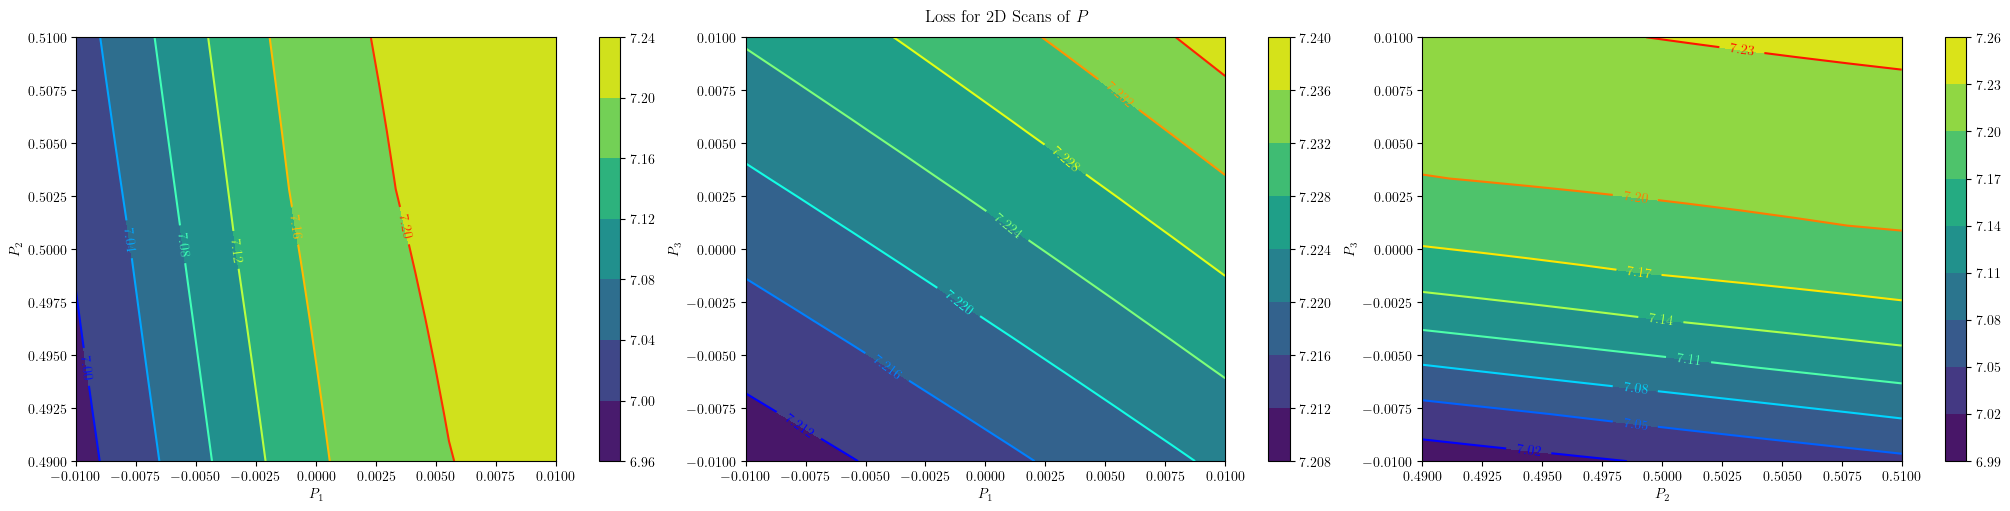

In [39]:
# # Get values of p

# from shared import plot_loss_2D
# from itertools import combinations

# fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

# n = 10
# s0 = np.array([0, 0, 0.5, 0, 0])
# p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
# controller.p = p_opt


# limits = (
#     (-0.01, 0.1),
#     (-0.01, 0.01),
#     (0.49, 0.51),
#     (-0.01, 0.01),
#     force_lim
# )
# scan_state_ranges = get_scan_states_ranges(n, limits)


# loss_hist = np.zeros((3, n, n))
# file_path = f"optimization_logs/t2_3_operating_range_2d.log"

# with open(file_path, "w") as file:
#     for k, c in enumerate(combinations([1, 2, 3], 2)):
#         p, q = c
#         range_x = scan_state_ranges[p]
#         range_y = scan_state_ranges[q]

#         x, y = np.meshgrid(range_x, range_y, indexing='ij')
#         for i in range(len(x)):
#             for j in range(len(y)):
#                 s = s0[:]
#                 s[p] = x[i][j]
#                 s[q] = y[i][j]
#                 loss = optimizer.total_loss_with_feedback(target, controller, s, p_opt, time=10, remap=True)
#                 loss_hist[k, j, i] = loss
            
#                 line = f"{np_to_string(s)}: {loss}"
#                 file.write(line + "\n")
        
#         plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])
# #         plot_rollout(x, y, axs, fig, label='with controller')
# #         plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
# #         fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)


# fig.suptitle('Loss for 2D Scans of $P$')
# fig.savefig("./assets2_revised/t2_3__operating_range_2d.png")


In [ ]:
# Get operatin ranges using 1D scans

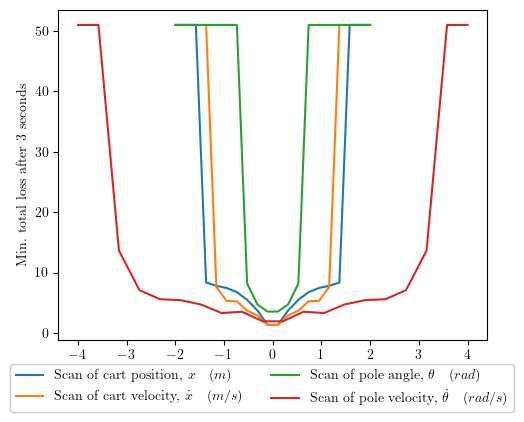

In [23]:
from optimizer import get_next_search_space_limits
from shared import STATE_LABELS, plot_loss_1D

n = 20
s0 = np.array([0., 0., 0., 0., 0.])
p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
controller.p = p_opt

limits = (
    (-2., 2.),
    (-2., 2.),
    (-2., 2.),
    (-4., 4.),
    force_lim
)
scan_state_ranges = get_scan_states_ranges(n, limits)
loss_hist = np.zeros((n, 4))
s_hist = np.zeros((n, 4, 4))

for i in range(4):
    for j, sii in enumerate(scan_state_ranges[i]):
        si = np.copy(s0)
        si[i] = sii
        loss = optimizer.total_loss_with_feedback(target, controller, si, p_opt, time=10, remap=True)
        
        loss_hist[j, i] = loss
        s_hist[j, i] = si[:4]

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(s_hist[:, i, i], loss_hist[:, i], label=f"Scan of {STATE_LABELS[i]}", fig=fig, ax=ax, time=3)

fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)


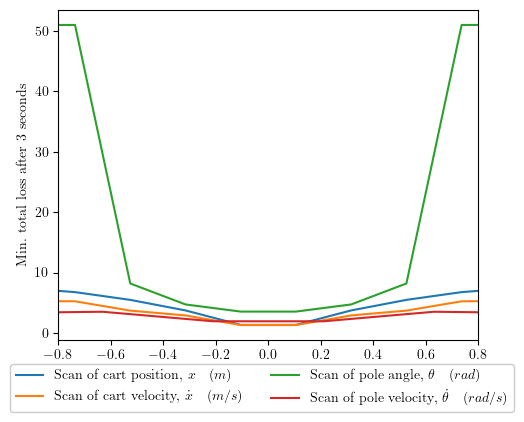

In [30]:
from optimizer import get_next_search_space_limits
from shared import STATE_LABELS, plot_loss_1D

n = 20
s0 = np.array([0., 0., 0., 0., 0.])
p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
controller.p = p_opt

limits = (
    (-2., 2.),
    (-2., 2.),
    (-2., 2.),
    (-4., 4.),
    (-6, 6),
)
scan_state_ranges = get_scan_states_ranges(n, limits)
loss_hist = np.zeros((n, 4))
s_hist = np.zeros((n, 4, 4))

for i in range(4):
    for j, sii in enumerate(scan_state_ranges[i]):
        si = np.copy(s0)
        si[i] = sii
        loss = optimizer.total_loss_with_feedback(target, controller, si, p_opt, time=10, remap=True)
        
        loss_hist[j, i] = loss
        s_hist[j, i] = si[:4]

fig, ax = plt.subplots(1, 1, figsize=(5, 4), layout='tight')
for i in range(4):
    plot_loss_1D(s_hist[:, i, i], loss_hist[:, i], label=f"Scan of {STATE_LABELS[i]}", fig=fig, ax=ax, time=3)

ax.set(xlim=(-0.8, 0.8))
fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)


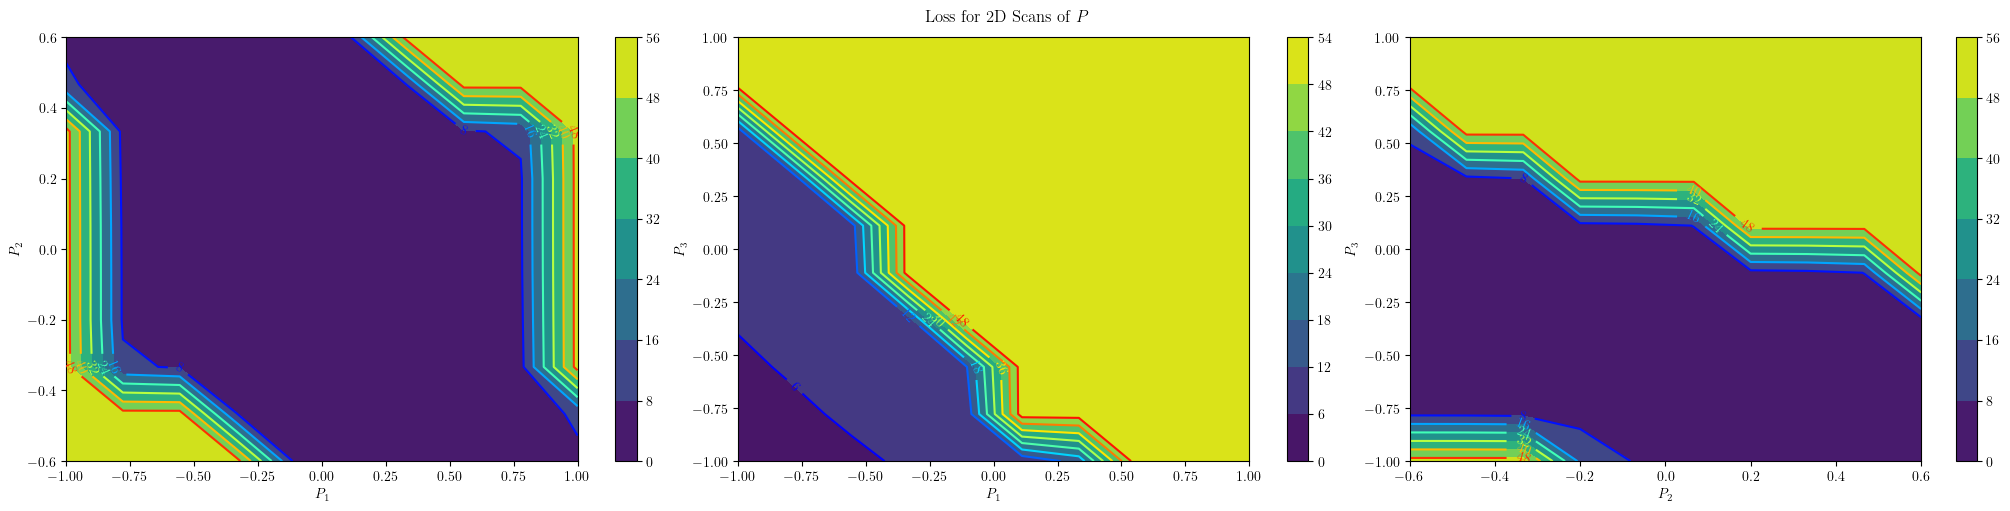

In [42]:
# Get values of p

from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0., 0., 0., 0., 0.])
p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
controller.p = p_opt


limits = (
    (-1, 1),
    (-1, 1),
    (-0.6, 0.6),
    (-1, 1),
    force_lim
)
scan_state_ranges = get_scan_states_ranges(n, limits)


loss_hist = np.zeros((3, n, n))
file_path = f"optimization_logs/t2_3_operating_range_2d.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = scan_state_ranges[p]
        range_y = scan_state_ranges[q]

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                s = s0[:]
                s[p] = x[i][j]
                s[q] = y[i][j]
                loss = optimizer.total_loss_with_feedback(target, controller, s, p_opt, time=10, remap=True)
                loss_hist[k, j, i] = loss
            
                line = f"{np_to_string(s)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])
#         plot_rollout(x, y, axs, fig, label='with controller')
#         plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
#         fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)


fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__operating_range_2d.png")


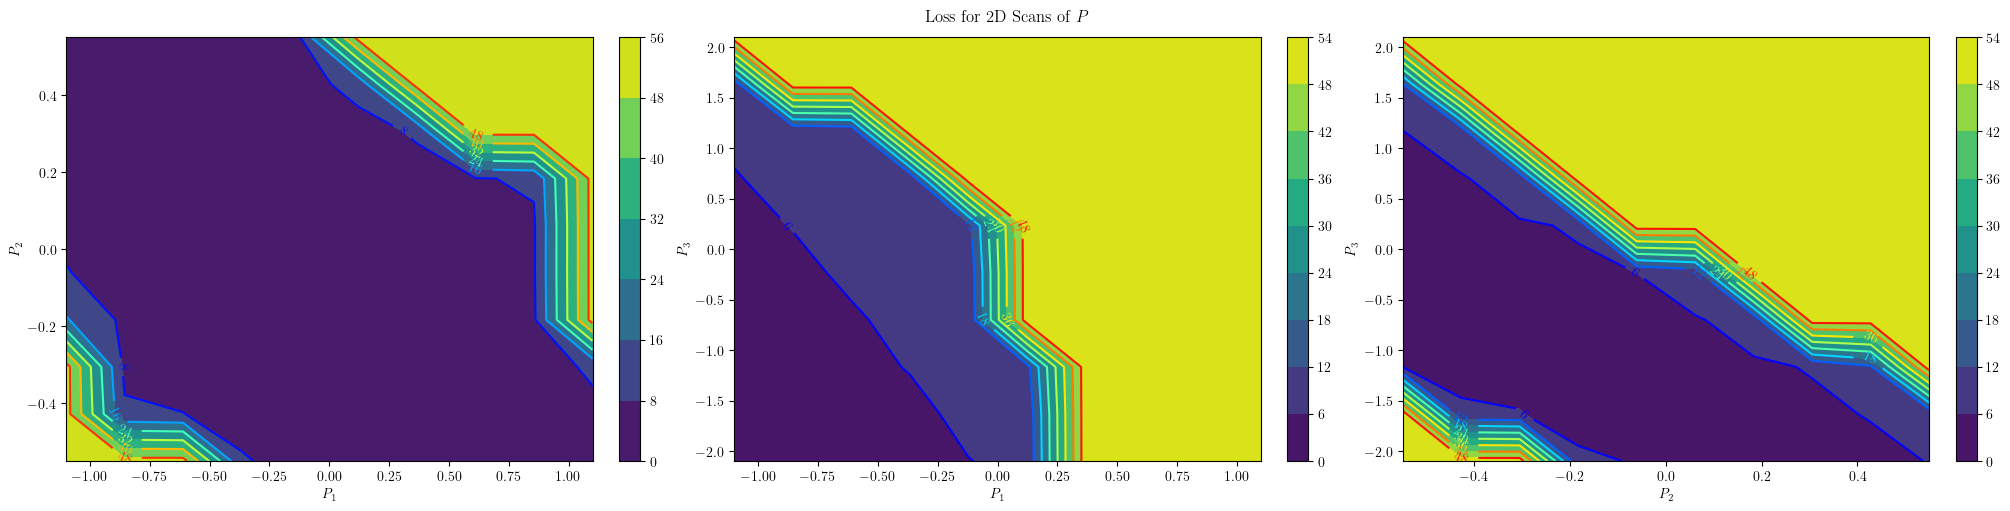

In [33]:
# Get values of p

from shared import plot_loss_2D
from itertools import combinations

fig, axs = plt.subplots(1, 3, figsize=(20, 5), layout='constrained')

n = 10
s0 = np.array([0.2, 0.2, 0.2, 0.2, 0.])
p_opt = np.array([ 1.82882224,  2.20082917, 19.37292826,  3.02057818])
controller.p = p_opt


limits = (
    (-1.4, 1.4),
    (-1.1, 1.1),
    (-0.55, 0.55),
    (-2.1, 2.1),
    (-6, 6)
)
scan_state_ranges = get_scan_states_ranges(n, limits)


loss_hist = np.zeros((3, n, n))
file_path = f"optimization_logs/t2_3_operating_range_2d.log"

with open(file_path, "w") as file:
    for k, c in enumerate(combinations([1, 2, 3], 2)):
        p, q = c
        range_x = scan_state_ranges[p]
        range_y = scan_state_ranges[q]

        x, y = np.meshgrid(range_x, range_y, indexing='ij')
        for i in range(len(x)):
            for j in range(len(y)):
                s = s0[:]
                s[p] = x[i][j]
                s[q] = y[i][j]
                loss = optimizer.total_loss_with_feedback(target, controller, s, p_opt, time=10, remap=True)
                loss_hist[k, j, i] = loss
            
                line = f"{np_to_string(s)}: {loss}"
                file.write(line + "\n")
        
        plot_loss_2D(x, y, loss_hist[k], p, q, fig=fig, ax=axs[k])
#         plot_rollout(x, y, axs, fig, label='with controller')
#         plot_rollout(x_no_controller, y_no_controller, axs, fig, label='no controller')
#         fig.legend(loc="lower center", framealpha=1, bbox_to_anchor=(0.52, -0.06), ncol=2)


fig.suptitle('Loss for 2D Scans of $P$')
fig.savefig("./assets2_revised/t2_3__operating_range_2d.png")
